## Credit default risk <a class='anchor' id='Section_1'>

Credit default risk is the risk that a lender takes the chance that a borrower fails to make required payments of the loan. 

Here KNN, logistic regression, decision tree, random forest and XGBoost will be exploited to find the best predicitve algorithms. RandomizedSearchCV and GridSearchCV will be implemented for hyperparamters-tuning. 



In [1]:
# import libraries and packages 
import os
import numpy as np 
import pandas as pd
import xgboost as xgb
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import uniform, randint
from sklearn import model_selection,linear_model, metrics
from sklearn.metrics import auc, accuracy_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV, train_test_split



In [2]:
Path = '/home/adminux/Documents/DeepLearning/Finance_Risk/CreditRisk'

for _, _, filenames in os.walk(Path):
    for filename in filenames:
        print(os.path.join(Path, filename))
        if os.path.splitext(filename)[-1].lower() == '.csv':
            datasetfile  = filename
        

/home/adminux/Documents/DeepLearning/Finance_Risk/CreditRisk/credit_risk_dataset.csv
/home/adminux/Documents/DeepLearning/Finance_Risk/CreditRisk/credit-xgb-modelling-93-3-accuracy.ipynb
/home/adminux/Documents/DeepLearning/Finance_Risk/CreditRisk/credit_risk_dataset.csv.zip
/home/adminux/Documents/DeepLearning/Finance_Risk/CreditRisk/credit-risk-exploratory-data-analysis.ipynb
/home/adminux/Documents/DeepLearning/Finance_Risk/CreditRisk/credit-risk-prediction.ipynb
/home/adminux/Documents/DeepLearning/Finance_Risk/CreditRisk/credit-xgb-modelling-93-3-accuracy-checkpoint.ipynb
/home/adminux/Documents/DeepLearning/Finance_Risk/CreditRisk/credit-risk-prediction-checkpoint.ipynb


## Exploratory Data Analysis <a class='anchor' id='Section_2'>

In [3]:
# read data into a DataFrame
credit_df = pd.read_csv(os.path.join(Path, datasetfile))
credit_df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [4]:
# check the data info
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [5]:
NaN_percentage = credit_df.isnull().sum()/credit_df.shape[0]*100
NaN_percentage.round(2)

person_age                    0.00
person_income                 0.00
person_home_ownership         0.00
person_emp_length             2.75
loan_intent                   0.00
loan_grade                    0.00
loan_amnt                     0.00
loan_int_rate                 9.56
loan_status                   0.00
loan_percent_income           0.00
cb_person_default_on_file     0.00
cb_person_cred_hist_length    0.00
dtype: float64

**Obeservation:** 
* Only two columns of data contains NaN, 
* `person_emp_length` contains **2.75%** NaN and `loan_int_rate` contains **9.56%** NaN

In [6]:
# check the mode, median for the two features
print('person_emp_length mode {}'.format(credit_df['person_emp_length'].mode()[0]))
print('person_emp_length median {}'.format(credit_df['person_emp_length'].median()))
print('loan_int_rate mode {}'.format(credit_df['loan_int_rate'].mode()[0]))
print('loan_int_rate median {}'.format(credit_df['loan_int_rate'].median()))

person_emp_length mode 0.0
person_emp_length median 4.0
loan_int_rate mode 7.51
loan_int_rate median 10.99


**Obeservation:**  
* `person_emp_length` is the person employment history, to be more conservative, the nan values are replaced with mode, which is 0 year.
* `loan_int_rate` is the loan income rate, to be more conservative, the nan values are replaced with 10.99, which is the median

In [7]:
# fill NaN with the mode
credit_df['person_emp_length'].fillna(credit_df['person_emp_length'].mode()[0], inplace=True)
credit_df['loan_int_rate'].fillna(credit_df['loan_int_rate'].median(), inplace=True)

In [8]:
# check the NaNs are replaced 
credit_df.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

In [9]:
# numerical variebles
num_cols = pd.DataFrame(credit_df[credit_df.select_dtypes(include=['float', 'int']).columns])
# print the numerical variebles
num_cols.columns

Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_cred_hist_length'],
      dtype='object')

In [10]:
# drop the label column 'loan status' before visualization
num_cols_hist = num_cols.drop(['loan_status'], axis=1)

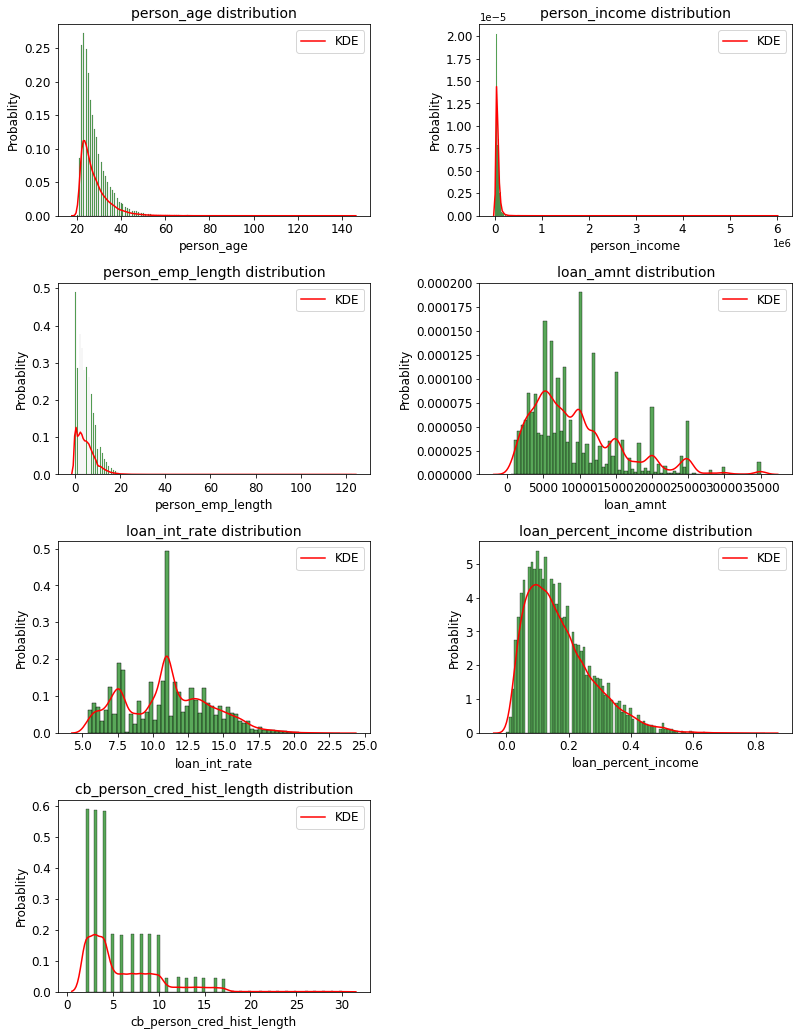

In [11]:
# visualize the distribution for each varieble
plt.figure(figsize=(12,16))

for i, col in enumerate(num_cols_hist.columns):
    idx = int('42'+ str(i+1))
    plt.subplot(idx)
    sns.histplot(num_cols_hist[col], color='forestgreen', stat='density') #, kde = True, kde_kws={'color': 'indianred', 'lw': 2, 'label': 'KDE'}
    sns.kdeplot(num_cols_hist[col], color='red')
    plt.title(col+' distribution', fontsize=14)
    plt.ylabel('Probablity', fontsize=12)
    plt.xlabel(col, fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(['KDE'], prop={"size":12})

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35,wspace=0.35)
plt.show()

In [12]:
# decribe the dataset
credit_df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,32581.000000,32581.000000,32581.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.658114,9589.371106,11.009620,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.159669,6322.086646,3.081611,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,8.490000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.110000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


**Observation:** All of the distributions are positive skewed.

* `person_age`: Most people are 20 to 60 years old. In the following analysis, to be more general, people age > 100 will be droped.
* `person_emp_length`: Most people have less than 40 years of employment. People with employment > 60 years will be droped.
* `person_income`: It seems that there are outliers which has to be removed (> 4 million).
* For all other variables, the distribution is more uniform across the whole range, thus they will be kept.


In [13]:
# clean the dataset and drop outliers
cleaned_credit_df = credit_df[credit_df['person_age']<=100]
cleaned_credit_df = cleaned_credit_df[cleaned_credit_df['person_emp_length']<=60]
cleaned_credit_df = cleaned_credit_df[cleaned_credit_df['person_income']<=4e6]

In [14]:
# get the cleaned numberical variebles
cleaned_num_cols = pd.DataFrame(cleaned_credit_df[cleaned_credit_df.select_dtypes(include=['float', 'int']).columns])

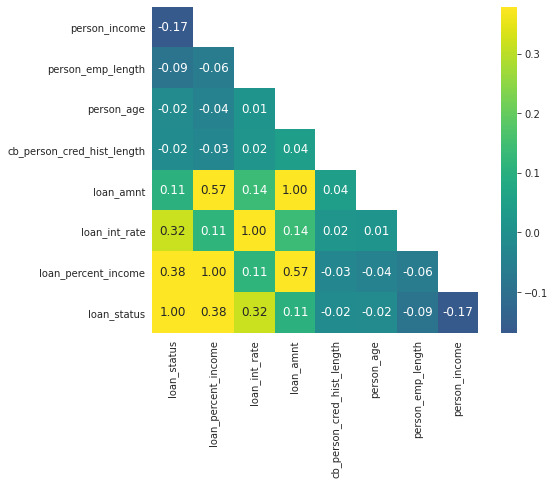

In [15]:
corr = cleaned_num_cols.corr().sort_values('loan_status', axis=1, ascending=False)
corr = corr.sort_values('loan_status', axis=0, ascending=True)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(8, 6))
    ax = sns.heatmap(corr, mask=mask, vmin=corr.loan_status.min(), 
                     vmax=corr.drop(['loan_status'], axis=0).loan_status.max(),
                     square=True, annot=True, fmt='.2f',
                     center=0, cmap='viridis',annot_kws={"size": 12})

**Observation:** 

* `person_income`, `person_emp_length`, and `person_age`: has negative effect on loan_status being default, which means the larger these variebles, the less likely the person is risky.
* `loan_percent_income`, `loan_int_rate`, and `loan_amnt`: has postive effect on loan_status being default, which means the larger these variebles, the more likely the person is risky.

In [16]:
# get the categorical variebles 
cat_cols = pd.DataFrame(cleaned_credit_df[cleaned_credit_df.select_dtypes(include=['object']).columns])
cat_cols.columns

Index(['person_home_ownership', 'loan_intent', 'loan_grade',
       'cb_person_default_on_file'],
      dtype='object')

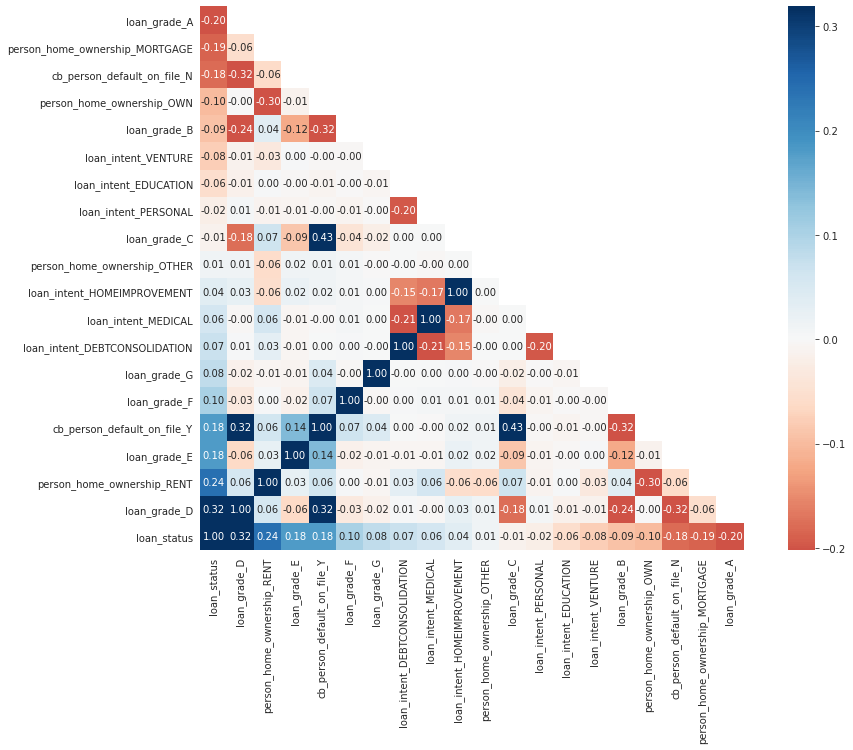

In [17]:
# one-hot encode the catogorical variebles
encoded_cat_cols = pd.get_dummies(cat_cols)
cat_cols_corr = pd.concat([encoded_cat_cols, cleaned_credit_df['loan_status']], axis=1)
corr = cat_cols_corr.corr().sort_values('loan_status', axis=1, ascending=False)
corr = corr.sort_values('loan_status', axis=0, ascending=True)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(16, 10))
    ax = sns.heatmap(corr, mask=mask, vmin=corr.loan_status.min(), 
                     vmax=corr.drop(['loan_status'], axis=0).loan_status.max(), 
                     square=True, annot=True, fmt='.2f',
                     center=0, cmap='RdBu',annot_kws={"size": 10})

In [18]:
# concat the numerical and one-hot encoded categorical variebles
cleaned_credit_df = pd.concat([cleaned_num_cols, encoded_cat_cols], axis=1)
cleaned_credit_df.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
1,21,9600,5.0,1000,11.14,0,0.10,2,0,0,...,0,0,1,0,0,0,0,0,1,0
2,25,9600,1.0,5500,12.87,1,0.57,3,1,0,...,0,0,0,1,0,0,0,0,1,0
3,23,65500,4.0,35000,15.23,1,0.53,2,0,0,...,0,0,0,1,0,0,0,0,1,0
4,24,54400,8.0,35000,14.27,1,0.55,4,0,0,...,0,0,0,1,0,0,0,0,0,1
5,21,9900,2.0,2500,7.14,1,0.25,2,0,0,...,1,1,0,0,0,0,0,0,1,0


In [19]:
# check the cleaned dataset size 
print ('The cleaned dataset has {} rows and {} columns'.format(cleaned_credit_df.shape[0], 
                                                               cleaned_credit_df.shape[1]))
print ('The cleaned dataset has {} numerical features and {} categorical features'
       .format(len(cleaned_num_cols.columns)-1, len(encoded_cat_cols.columns)))

The cleaned dataset has 32574 rows and 27 columns
The cleaned dataset has 7 numerical features and 19 categorical features


## Modeling

In [20]:
# Split Train and Test Sets
label = cleaned_credit_df['loan_status'] # labels
features = cleaned_credit_df.drop('loan_status',axis=1) # features
x_train, x_test, y_train, y_test = model_selection.train_test_split(features, label, 
                                                                    random_state=101, test_size=.25)
print('The train dataset has {} data\nThe test dataset has {} data'.
      format(x_train.shape[0], x_test.shape[0]))


The train dataset has 24430 data
The test dataset has 8144 data


In [21]:
# define a model assess function to test a few model performance
def model_assess(model, name='Default'):
    '''
    This function is used to test model performance 
    
    Input: model, defined classifer
    Output: print the confusion matrix
    
    '''
    
    model.fit(x_train, y_train)
    preds = model.predict(x_test)
    preds_proba = model.predict_proba(x_test)
    print(name, '\n',classification_report(y_test, model.predict(x_test)))

### Evaluate different algorithms

In [22]:
#KNN
knn = KNeighborsClassifier(n_neighbors=150)
model_assess(knn, name='KNN')
#Logistic Regression
lg = LogisticRegression(random_state=101)
model_assess(lg, 'Logistic Regression')
# Dicision trees
D_tree = DecisionTreeClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=1, random_state=101)
model_assess(D_tree, 'DecisionTree Classifier')
# RandomForest
rf = RandomForestClassifier(random_state=101)
model_assess(rf, 'RandomForest Classifier')
# GB 
gb = GradientBoostingClassifier(random_state=101)
model_assess(gb, 'GradientBoosting Classifier')
#XGB
xgb1 = xgb.XGBClassifier(objective='binary:logistic', eval_metric = 'logloss', random_state=101) 
model_assess(xgb1, 'XGBoost')

KNN 
               precision    recall  f1-score   support

           0       0.85      0.96      0.90      6357
           1       0.71      0.40      0.51      1787

    accuracy                           0.83      8144
   macro avg       0.78      0.68      0.70      8144
weighted avg       0.82      0.83      0.81      8144

Logistic Regression 
               precision    recall  f1-score   support

           0       0.81      0.98      0.89      6357
           1       0.71      0.17      0.27      1787

    accuracy                           0.80      8144
   macro avg       0.76      0.58      0.58      8144
weighted avg       0.79      0.80      0.75      8144

DecisionTree Classifier 
               precision    recall  f1-score   support

           0       0.92      0.99      0.96      6357
           1       0.95      0.71      0.81      1787

    accuracy                           0.93      8144
   macro avg       0.94      0.85      0.88      8144
weighted avg       0

/home/adminux/anaconda3/envs/tf2.4/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBoost 
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      6357
           1       0.95      0.74      0.84      1787

    accuracy                           0.94      8144
   macro avg       0.94      0.87      0.90      8144
weighted avg       0.94      0.94      0.93      8144



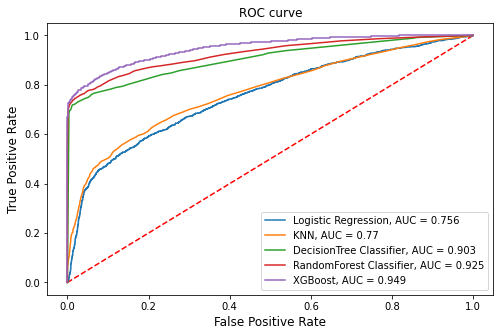

In [23]:
#ROC AUC
fig = plt.figure(figsize=(8,5))
plt.plot([0, 1], [0, 1],'r--')

#Logistic Regression
preds_proba_lg = lg.predict_proba(x_test)
probslg = preds_proba_lg[:, 1]
fpr, tpr, thresh = metrics.roc_curve(y_test, probslg)
auclg = roc_auc_score(y_test, probslg)
plt.plot(fpr, tpr, label='Logistic Regression, AUC = {}'.format(str(round(auclg,3))))

#KNN
preds_proba_knn = knn.predict_proba(x_test)
probsknn = preds_proba_knn[:, 1]
fpr, tpr, thresh = metrics.roc_curve(y_test, probsknn)
aucknn = roc_auc_score(y_test, probsknn)
plt.plot(fpr, tpr, label='KNN, AUC = {}'.format(str(round(aucknn,3))))

#DecisionTree Classifier
preds_proba_D_tree = D_tree.predict_proba(x_test)
probsD_tree = preds_proba_D_tree[:, 1]
fpr, tpr, thresh = metrics.roc_curve(y_test, probsD_tree)
aucdt = roc_auc_score(y_test, probsD_tree)
plt.plot(fpr, tpr, label='DecisionTree Classifier, AUC = {}'.format(str(round(aucdt,3))))

#RandomForest Classifier
preds_proba_rf = rf.predict_proba(x_test)
probsrf = preds_proba_rf[:, 1]
fpr, tpr, thresh = metrics.roc_curve(y_test, probsrf)
aucrf = roc_auc_score(y_test, probsrf)
plt.plot(fpr, tpr, label='RandomForest Classifier, AUC = {}'.format(str(round(aucrf,3))))

#XGBoost
preds_proba_xgb = xgb1.predict_proba(x_test)
probsxgb = preds_proba_xgb[:, 1]
fpr, tpr, thresh = metrics.roc_curve(y_test, probsxgb)
aucxgb = roc_auc_score(y_test, probsxgb)
plt.plot(fpr, tpr, label='XGBoost, AUC = {}'.format(str(round(aucxgb,3))))


plt.ylabel("True Positive Rate", fontsize=12)
plt.xlabel("False Positive Rate", fontsize=12)
plt.title("ROC curve")
plt.rcParams['axes.titlesize'] = 16
plt.legend()
plt.show()

### Feature importance

In [24]:
feature_importance = pd.DataFrame({'feature': x_train.columns, 
                                   'importance': xgb1.feature_importances_})

new_features_df = feature_importance[feature_importance['importance']>0
                                    ].sort_values(by=['importance'],ascending=False)

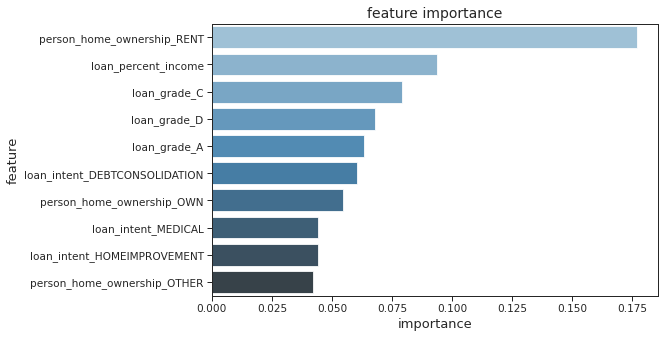

In [25]:
sns.set(context='paper', style='ticks',  font='sans-serif', 
        font_scale=1.2, color_codes=True, rc=None)
figure, ax = plt.subplots(figsize=(8, 5))
ax=sns.barplot(data = new_features_df[:10],
              y='feature',
              x='importance',
              palette='Blues_d') # rocket, Blues_d
ax.set_title('feature importance', fontsize=14)
ax.set_xlabel('importance', fontsize=13)
ax.set_ylabel('feature', fontsize=13)
plt.show()

### Hyperparameter Tuning

In [27]:
# RandomizedSearchCV hyperparameter tuning
params = {
    "colsample_bytree": uniform(0.7, 0.2), # 0.9-1 0.9 is the lower bound, 0.1 is the range
    "gamma": uniform(0.2, 0.3),# 0.2-0.5
    "learning_rate": uniform(0.2, 0.3), # 0.2-0.4 
    "max_depth": randint(4, 6), # 4, 5, 6
    "n_estimators": randint(100, 300), # 100-300
    "subsample": uniform(0.7, 0.2) # 0.9-1
}

Random_CV = RandomizedSearchCV(xgb1, param_distributions=params, random_state=101, 
                            n_iter=100, cv=3, verbose=2, n_jobs=16, return_train_score=True)

Random_CV.fit(x_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/home/adminux/anaconda3/envs/tf2.4/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           eval_metric='logloss', gamma=0,
                                           gpu_id=-1, importance_type='gain',
                                           interaction_constraints='',
                                           learning_rate=0.300000012,
                                           max_delta_step=0, max_depth=6,
                                           min_child_weight=1, missing=nan,
                                           monotone_constraints='()',
                                           n_estimato...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7a5c830eb0>,
        

In [28]:
# function to return the top selcted models
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
report_best_scores(Random_CV.cv_results_, 3)

Model with rank: 1
Mean validation score: 0.936 (std: 0.003)
Parameters: {'colsample_bytree': 0.8032797255404892, 'gamma': 0.3712002760604419, 'learning_rate': 0.2085422679434291, 'max_depth': 5, 'n_estimators': 175, 'subsample': 0.8370553963394625}

Model with rank: 2
Mean validation score: 0.935 (std: 0.003)
Parameters: {'colsample_bytree': 0.8202198779933132, 'gamma': 0.47298643676266666, 'learning_rate': 0.2274121660309521, 'max_depth': 5, 'n_estimators': 113, 'subsample': 0.8981797516989936}

Model with rank: 3
Mean validation score: 0.935 (std: 0.003)
Parameters: {'colsample_bytree': 0.8245679564059827, 'gamma': 0.4158858337235706, 'learning_rate': 0.33522078385332643, 'max_depth': 4, 'n_estimators': 194, 'subsample': 0.8465142862420739}



In [29]:
Random_best_xgb = Random_CV.best_estimator_
Random_best_xgb.fit(x_train, np.ravel(y_train)) 
preds_proba_Random = Random_best_xgb.predict_proba(x_test)
probs_Random = preds_proba_Random[:, 1]
Random_bestauc = roc_auc_score(y_test, probs_Random)
print ('xgb base model AUROC socre: {}'.format(aucxgb))
print ('xgb best model using RandomizedSearchCV AUROC socre: {}'.format(Random_bestauc))

xgb base model AUROC socre: 0.9486224378098548
xgb best model using RandomizedSearchCV AUROC socre: 0.9478652167670675


In [49]:
# GridSearchCV hyperparameter tuning
params = {
    "colsample_bytree": [0.9, 0.91],
    "gamma": [0.45],
    "learning_rate": [0.26], # default 0.1 
    "max_depth": [5], # default 3
    "n_estimators": [150, 157, 160], # default 100
    "subsample": [0.98, 0.97, 0.96]
}

Grid_CV = GridSearchCV(xgb, param_grid=params, cv=3, verbose=1, n_jobs=16, return_train_score=True)
Grid_CV.fit(x_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   29.8s
[Parallel(n_jobs=16)]: Done  54 out of  54 | elapsed:  1.1min finished


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=0,
                                     num_parallel_tree=1, random_state=42,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                                     tree_method='exact', validate_parameters=1,
        

In [50]:
report_best_scores(Grid_CV.cv_results_, 3)

Model with rank: 1
Mean validation score: 0.935 (std: 0.001)
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.45, 'learning_rate': 0.26, 'max_depth': 5, 'n_estimators': 150, 'subsample': 0.96}

Model with rank: 1
Mean validation score: 0.935 (std: 0.001)
Parameters: {'colsample_bytree': 0.91, 'gamma': 0.45, 'learning_rate': 0.26, 'max_depth': 5, 'n_estimators': 150, 'subsample': 0.96}

Model with rank: 3
Mean validation score: 0.934 (std: 0.001)
Parameters: {'colsample_bytree': 0.9, 'gamma': 0.45, 'learning_rate': 0.26, 'max_depth': 5, 'n_estimators': 157, 'subsample': 0.97}

Model with rank: 3
Mean validation score: 0.934 (std: 0.001)
Parameters: {'colsample_bytree': 0.91, 'gamma': 0.45, 'learning_rate': 0.26, 'max_depth': 5, 'n_estimators': 157, 'subsample': 0.97}



In [51]:
Grid_best_xgb = Grid_CV.best_estimator_
Grid_best_xgb.fit(x_train, np.ravel(y_train)) 
preds_proba_Grid = Grid_best_xgb.predict_proba(x_test)
probs_Grid = preds_proba_Grid[:, 1]
Grid_bestauc = roc_auc_score(y_test, probs_Grid)
print ('xgb base model AUROC socre: {}'.format(aucxgb))
print ('xgb best model using RandomizedSearchCV AUROC socre: {}'.format(Random_bestauc))
print ('xgb best model using GridSearchCV AUROC socre: {}'.format(Grid_bestauc))

xgb base model AUROC socre: 0.9547183395264366
xgb best model using RandomizedSearchCV AUROC socre: 0.9563440367629163
xgb best model using GridSearchCV AUROC socre: 0.9571280397014439


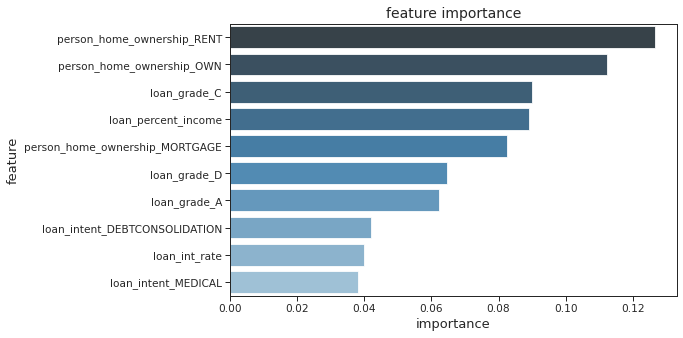

In [52]:
# display feature and their importance of the best model
feature_importance = pd.DataFrame({'feature': x_train.columns, 
                                   'importance': Grid_best_xgb.feature_importances_})

new_features_df = feature_importance[feature_importance['importance']>0
                                    ].sort_values(by=['importance'],ascending=False)

sns.set(context='paper', style='ticks',  font='sans-serif', 
        font_scale=1.2, color_codes=True, rc=None)
figure, ax = plt.subplots(figsize=(8, 5))
ax=sns.barplot(data = new_features_df[:10],
              y='feature',
              x='importance',
              palette='Blues_d') # rocket, Blues_d
ax.set_title('feature importance', fontsize=14)
ax.set_xlabel('importance', fontsize=13)
ax.set_ylabel('feature', fontsize=13)
plt.show()


In [56]:
# display the top 10 important features
new_features_df.head(10)

,feature,importance
10,person_home_ownership_RENT,0.126772
9,person_home_ownership_OWN,0.112281
19,loan_grade_C,0.089884
5,loan_percent_income,0.088991
7,person_home_ownership_MORTGAGE,0.082585
20,loan_grade_D,0.064588
17,loan_grade_A,0.062319
11,loan_intent_DEBTCONSOLIDATION,0.041880
4,loan_int_rate,0.039860
14,loan_intent_MEDICAL,0.038173


**Observation**

The top 5 important features includes:
* `person_home_ownership_RENT`
* `person_home_ownership_OWN`
* `loan_grade_C`
* `loan_percent_income`
* `person_home_ownership_MORTGAGE`

In [58]:
# select the top 20 features and then retrain the model
new_features = new_features_df['feature'][0:20]
new_features

10        person_home_ownership_RENT
9          person_home_ownership_OWN
19                      loan_grade_C
5                loan_percent_income
7     person_home_ownership_MORTGAGE
20                      loan_grade_D
17                      loan_grade_A
11     loan_intent_DEBTCONSOLIDATION
4                      loan_int_rate
14               loan_intent_MEDICAL
13       loan_intent_HOMEIMPROVEMENT
21                      loan_grade_E
1                      person_income
16               loan_intent_VENTURE
8        person_home_ownership_OTHER
23                      loan_grade_G
18                      loan_grade_B
22                      loan_grade_F
2                  person_emp_length
0                         person_age
Name: feature, dtype: object

In [61]:
# Split Train and Test Sets
new_features_df = pd.DataFrame(cleaned_credit_df[new_features])
new_features_df.shape

(32574, 20)

In [62]:
x_train1, x_test1, y_train1, y_test1 = model_selection.train_test_split(new_features_df, label, 
                                                                    random_state=42, test_size=.30)
print('The train dataset has {} data\nThe test dataset has {} data'.
      format(x_train.shape[0], x_test.shape[0]))

The train dataset has 22801 data
The test dataset has 9773 data


In [63]:
# RandomizedSearchCV hyperparameter tuning
params = {
    "colsample_bytree": uniform(0.9, 0.1), # 0.9-1 0.9 is the lower bound, 0.1 is the range
    "gamma": uniform(0.2, 0.3),# 0.2-0.5
    "learning_rate": uniform(0.2, 0.2), # 0.2-0.4 
    "max_depth": randint(4, 6), # 4, 5, 6
    "n_estimators": randint(100, 300), # 100-300
    "subsample": uniform(0.9, 0.1) # 0.9-1
}

Random_CV = RandomizedSearchCV(xgb, param_distributions=params, random_state=42, 
                            n_iter=100, cv=3, verbose=2, n_jobs=16, return_train_score=True)

Random_CV.fit(x_train1, y_train1)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:   25.7s
[Parallel(n_jobs=16)]: Done 130 tasks      | elapsed:  3.0min
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:  6.3min finished


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           gpu_id=-1, importance_type='gain',
                                           interaction_constraints='',
                                           learning_rate=0.300000012,
                                           max_delta_step=0, max_depth=6,
                                           min_child_weight=1, missing=nan,
                                           monotone_constraints='()',
                                           n_estimators=100, n_jobs=0,
                                           num_pa...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f1156e80190>,
       

In [64]:
report_best_scores(Random_CV.cv_results_, 3)

Model with rank: 1
Mean validation score: 0.935 (std: 0.001)
Parameters: {'colsample_bytree': 0.975784611046437, 'gamma': 0.20431804658892677, 'learning_rate': 0.22321452810138326, 'max_depth': 4, 'n_estimators': 146, 'subsample': 0.904072880231897}

Model with rank: 2
Mean validation score: 0.934 (std: 0.001)
Parameters: {'colsample_bytree': 0.9326540768805835, 'gamma': 0.3711331923216198, 'learning_rate': 0.30416685200516475, 'max_depth': 5, 'n_estimators': 139, 'subsample': 0.9844533848678152}

Model with rank: 3
Mean validation score: 0.934 (std: 0.002)
Parameters: {'colsample_bytree': 0.9023271935735826, 'gamma': 0.4443405447766807, 'learning_rate': 0.25637095495468, 'max_depth': 5, 'n_estimators': 157, 'subsample': 0.9696737165364151}



In [65]:
Random_best_xgb = Random_CV.best_estimator_
Random_best_xgb.fit(x_train, np.ravel(y_train)) 
preds_proba_Random = Random_best_xgb.predict_proba(x_test1)
probs_Random = preds_proba_Random[:, 1]
Random_bestauc = roc_auc_score(y_test1, probs_Random)
print ('xgb base model AUROC socre: {}'.format(aucxgb))
print ('xgb best model using RandomizedSearchCV AUROC socre: {}'.format(Random_bestauc))

xgb base model AUROC socre: 0.9547183395264366
xgb best model using RandomizedSearchCV AUROC socre: 0.9549855061930421


**Observation**

it turns out after dropping some features, the model is only improved to 0.955, thus no furhter GridSearchCV is performed. And the original GridSearchCV best model will be used for futher threshhold optimizaiton. 

### Threshold Optimization

In [77]:
preds = Grid_best_xgb.predict_proba(x_test) # 1st col = pred val, 2nd col = pred prob

pred_probs = pd.DataFrame(preds[:,1],columns = ['Default Probability'])

pd.concat([pred_probs, y_test.reset_index(drop=True)],axis=1)
thresh = np.linspace(0,1,41)
thresh

array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
       0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
       0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 ,
       0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875,
       0.9  , 0.925, 0.95 , 0.975, 1.   ])

In [87]:
def optimize_threshold(predict,thresholds =thresh, y_true = y_test):
    data = predict
    
    def_recalls = []
    nondef_recalls = []
    accs =[]

    
    for threshold in thresholds:
        # predicted values for each threshold
        data['loan_status'] = data['Default Probability'].apply(lambda x: 1 if x > threshold else 0 )
        
        accs.append(metrics.accuracy_score(y_true, data['loan_status']))
        
        stats = metrics.precision_recall_fscore_support(y_true, data['loan_status'], zero_division=0)
        
        def_recalls.append(stats[1][1])
        nondef_recalls.append(stats[1][0])
        
        
    return accs, def_recalls, nondef_recalls

accs, def_recalls, nondef_recalls = optimize_threshold(pred_probs)


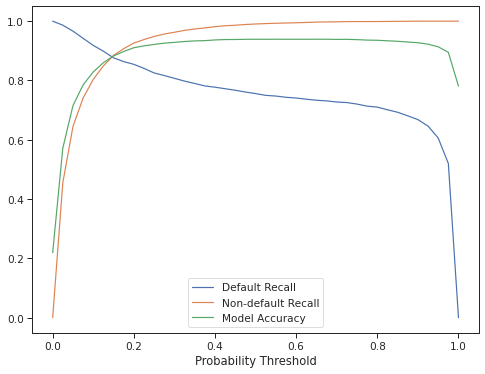

In [88]:
figure = plt.subplots(figsize=(8, 6))
plt.plot(thresh,def_recalls)
plt.plot(thresh,nondef_recalls)
plt.plot(thresh,accs)
plt.xlabel("Probability Threshold")
plt.legend(["Default Recall","Non-default Recall","Model Accuracy"])
plt.show()

In [95]:
optim_threshold = accs.index(max(accs))

print('The model accuracy is {} using the optimal probabilty threshold'
      .format(round(accs[optim_threshold],3)))

print ('The optimal probabilty threshold is {}'.format(thresh[optim_threshold]))

The model accuracy is 0.939 using the optimal probabilty threshold
The optimal probabilty threshold is 0.55


** Discussion**

* The XGBClassifier has the best performance with AUROC score compared to other classifiers.

* Using RandomizedSearchCV for hyperparamters-tuning improves AUROC score.

* GridSearchCV can improve AUROC score further with fine-tuning around optimised hyperparameters. 

* The optimal probability threshold for the best model is 0.55 resulting accuracy 0.939.

